<a href="https://colab.research.google.com/github/valesierrai/Analisis-Supervisado-para-el-AD/blob/main/Modelos_de_ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de ensamble

Ya se ha visto que los árboles de decisión son modelos que funcionan muy bien, en general mejor que los modelos lineales, y tienen varias ventajas como:
- Son fácilmente interpretables.
- Con ellos no es necesario hacer preprocesamientos complejos, porque son no paramétricos, es decir, no hacen supuestos sobre las distribuciones de los datos.
- Gestionan de manera natural los datos nulos o faltantes, tampoco es necesario hacer eliminación o imputación previa de datos nulos.

Sin embargo, los árboles de decisión tienen 2 problemas importantes:
- Son muy inestables: pequeños cambios en los datos pueden llevar a cambios drásticos en el modelo.
- Tienden a sobreajustarse muy fácilmente.

Estos problemas pueden ser resueltos trabajando con muchos árboles simultáneamente. Estos modelos que trabajan con muchos árboles se conocen como modelos de ensamble.

Vamos a empezar a conocerlos de los más simples a los más complejos.

In [ ]:
# Cargamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Importamos Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargamos la base de datos
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizaje Supervisado/auto-mpg.data', sep='\s+', header=None, na_values='?')
# Definimos los nombres de las columnas
cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
df.columns = cols
# Fijamos como índice el nombre del carro (como identificador único)
df.set_index('car name', inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 28.0+ KB


Para tener un punto de comparación, vamos a entrenar 2 modelos de clasificación, uno lineal y uno de árbol.

## Clasificador lineal

In [ ]:
from sklearn.model_selection import train_test_split

# Eliminamos registros con NA
df_dropna = df.dropna()
# La variable objetivo será el origen
X = df_dropna.drop(columns=['origin'])
# Separamos las observaciones de las etiquetas
y = df_dropna['origin']
# Hacemos la separación de entranamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
# Verificamos los tamaños de los conjuntos
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (274, 7) (274,)
Test: (118, 7) (118,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score

# Generamos una lista con los nombres de las variables numéricas flotantes
num_vars = ['displacement', 'horsepower', 'weight', 'acceleration', 'mpg'] # Se definen las variables numéricas
# Instanciamos los codificadores para las variables numéricas enteras
oe_cyl = OrdinalEncoder(categories=[[3., 4., 5., 6., 8.]]) #el 3. hace que este se vuelva flotante (x.)
oe_my = OrdinalEncoder(categories=[[70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.]])

# Instanciamos el escalador para las variables numéricas
ss = StandardScaler()
# Instanciamos el preprocesador
preprocessor = ColumnTransformer(transformers = [('oe_cylinders', oe_cyl, ['cylinders']), # Codificación ordinal para la variable 'cylinders'
                                               ('oe_model_year', oe_my, ['model year']), # Codificación ordinal para la variable 'model_year'
                                               ('ss', ss, num_vars)], # Prepocesamiento de las variables numéricas
                                               remainder = 'passthrough') # El resto de las columnas se mantienen sin cambios
# Instanciamos el clasificador
model = LogisticRegression(max_iter = 10000, solver = 'liblinear', class_weight = 'balanced') # Se define el modelo
# Instanciamos el pipeline
pipe = Pipeline([('preprocessor', preprocessor), ('model', model)]) #Organizar un poco mejor el proceso del modelo
# Definimos los hiperparámetros que sintonizaremos en el clasificador
dist = {'model__C':loguniform(1e-3, 1e3), 'model__penalty':['l1', 'l2']}

# Hacemos la búsqueda de hiperparámetros
grid_search = RandomizedSearchCV(estimator = pipe, param_distributions = dist, scoring = 'f1_weighted', cv = 5)
grid_search.fit(X_train, y_train)

# Encontramos el desempeño para el test
test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average = 'weighted')

print(f'Best validation score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best validation score: 0.770 with {'model__C': 6.703825475856579, 'model__penalty': 'l1'}
Test score: 0.802


In [ ]:
from sklearn.metrics import classification_report
# Imprimimos el  reporte de clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.92      0.92      0.92        74
           2       0.60      0.45      0.51        20
           3       0.62      0.75      0.68        24

    accuracy                           0.81       118
   macro avg       0.71      0.71      0.70       118
weighted avg       0.80      0.81      0.80       118



**support:** cuantas muestras hay de cada clase (puedo ver si hay desbalanceo)



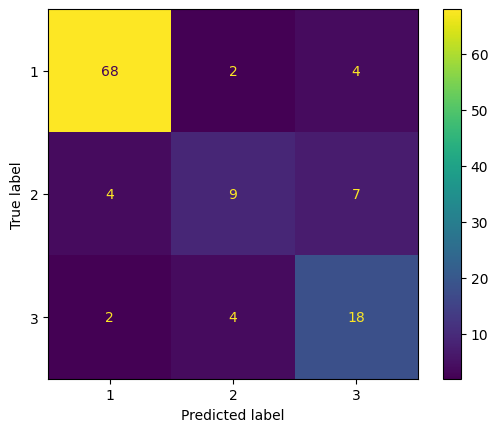

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
# Visualizamos la matriz de confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

## Árbol de decisión

In [ ]:
from sklearn.model_selection import train_test_split
# Procedemos igual al caso del clasificador lineal
X = df.drop(columns=['origin'])
y = df['origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (278, 7) (278,)
Test: (120, 7) (120,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Hacemos poda con ccp_alpha
dist = {'ccp_alpha':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = dist, scoring = 'f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average='weighted')

print(f'Best validation score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best validation score: 0.802 with {'ccp_alpha': 0.00748912486226376}
Test score: 0.798


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.88      0.89      0.89        75
           2       0.68      0.71      0.70        21
           3       0.64      0.58      0.61        24

    accuracy                           0.80       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.80      0.80      0.80       120



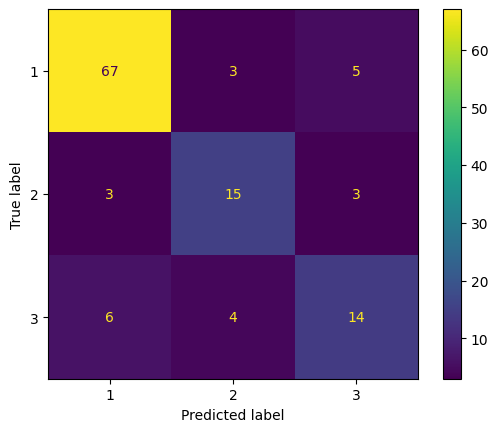

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

# Modelos bagging

La primera pregunta que surge es ¿que sentido tiene entrenar muchos árboles con los mismos datos?. En realidad, entrenar muchos estimadores del mismo tipo con el mismo conjunto de datos, conducirá a tener modelos muy similares, y el problema del sobreajuste no se solucionará. En realidad, lo ideal sería tener *un conjunto de datos diferente* para entrenar cada árbol.

¿Cómo conseguimos tener muchos conjuntos de datos diferentes? Usando técnicas de *remuestreo*.

La técnica de remuestreo más utilizada es el *bootstrap*, que consiste en hacer un nuevo dataset del mismo tamaño que conjunto de datos original, eligiendo al azar observaciones de este *una por una*, reemplazando las observaciones que van siendo elegidas. Esto significa que algunas observaciones pueden ser elegidas más de una vez, y algunos pueden no ser elegidas en absoluto. La gráfica siguiente lo ilustra:

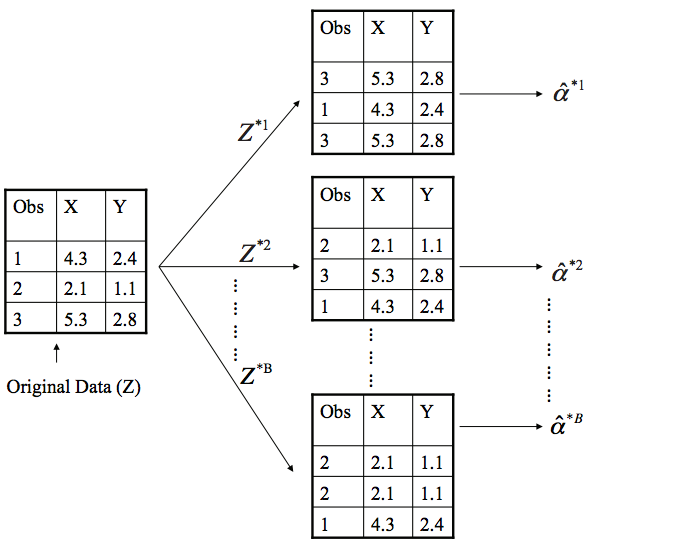

De este manera, podemos generar tantos conjuntos de datos como estimadores por entrenar tengamos. De esta manera, podemos entrenar cada estimador *de manera independiente*, y en paralelo si tenemos varios procesadores.

La siguiente pregunta que surge es ¿cómo se hace una predicción única si todos los estimadores pueden hacer predicciones diferentes?

En modelos de regresión la predicción es el valor promedio de las predicciones de los estimadores, y en clasificación, la predicción es la clase que más frecuentemente ha sido predicha por los estimadores.

Un modelo que funciona así se llama modelo de *Bagging*, y vamos a ver como se codifica.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Instanciamos el modelo de ensamble con los árboles como clasificadores. Tendremos 100 árboles
bag_model = BaggingClassifier(estimator = DecisionTreeClassifier(), n_estimators = 100, random_state = 77)
# Entrenamos el modelo
bag_model.fit(X_train, y_train)
train_score = f1_score(y_train, bag_model.predict(X_train), average = 'weighted')
test_score = f1_score(y_test, bag_model.predict(X_test), average = 'weighted')
print(f'Train score: {train_score:.2f}')
print(f'Test score: {test_score:.2f}')

Train score: 1.00
Test score: 0.85


Este modelo está sobreajustado, así que hay que regularizarlo.

En este caso, se pueden regularizar los árboles limitando la profundidad, y se puede sintonizar el número de estimadores a usar.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import loguniform

bag_model = BaggingClassifier(estimator = DecisionTreeClassifier(ccp_alpha = 0.01)) #Bajr el overfitting del árbol (ccp_alpha)
dist = {'n_estimators':range(1, 201)}
grid_search = RandomizedSearchCV(estimator = bag_model, param_distributions = dist, cv = 5, scoring = 'f1_weighted')
grid_search.fit(X_train, y_train)

print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.81 with {'n_estimators': 33}
Test score: 0.84


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.88      0.93      0.90        75
           2       0.65      0.71      0.68        21
           3       0.94      0.67      0.78        24

    accuracy                           0.84       120
   macro avg       0.82      0.77      0.79       120
weighted avg       0.85      0.84      0.84       120



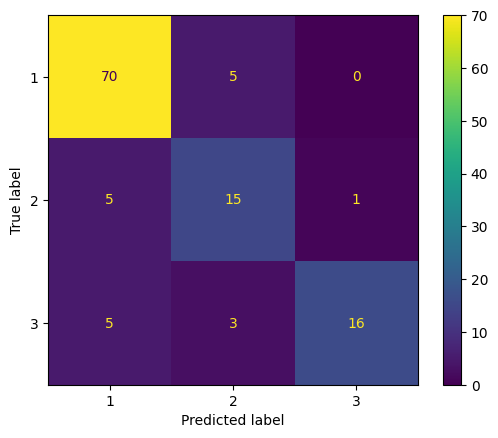

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Vemos que este modelo tiene mejor desempeño que los modelos lineal y de único árbol.

# Random Forest

Hacer bootstrapping soluciona el problema de tener muchos datasets. Sin embargo, los datasets generados, al provenir de un único dataset, tienen similaridades entre sí, es decir que no son independientes, y esta condición es deseable para minimizar el *sesgo* que puedan tener los árboles.

Una posible solución, al menos parcialmente, es entrenar cada estimador con *características diferentes*. Esto es lo que hacen los modelos de bosques alaetorios - *Random Forest*.

Un *bosque aleatorio* es un modelo de ensamble formado por muchos árboles de decisión, donde cada uno de ellos es entrenado con un conjunto de datos diferentes generado por la técnica de *bootstrapping*; adicionalmente, para lograr una mayor diversidad de los estimadores, en cada nodo del árbol se selecciona aleatoriamente un subconjunto de características, de las cuales se escogerá la siguiente a usar para particionar el árbol.

Para regularizar un bosque aleatorio y evitar que se sobreajuste existen varios hiperparámetros que se pueden sintonizar; entre estos están:
1. n_estimators: Este hiperparámetro controla la cantidad de árboles de decisión dentro del bosque. Aunque se podría pensar que usar muchos árboles para ajustar un modelo ayudan a obtener un resultado más generalizable, esto no siempre es así. Aunque no causan ningún sobreajuste, aumentan la complejidad temporal del modelo.
2. max_depth: Este hiperparámetro rige la profundidad máxima hasta la que pueden crecer los árboles dentro del bosque. A medida que aumentamos la profundidad del árbol, la precisión del modelo aumenta hasta cierto límite, pero luego comenzará a disminuir gradualmente debido al sobreajuste en el modelo.
3. min_samples_split: Este hiperparámetro especifica la cantidad mínima de muestras que debe tener un nodo interno para dividirse en más nodos. Si tenemos un valor muy bajo de min_samples_splits, entonces, en este caso, el árbol continuará creciendo y comenzará a sobreajustarse.
4. max_features: Este hiperparámetro determina la cantidad de características que se deben considerar al buscar la mejor división. Se puede establecer como un número entero, flotante, string o None. Si es un entero, entonces considera ese número de características en cada división. Si es flotante, entonces muestra un porcentaje y las características $int(max_features * n_features)$ son consideradas en cada división. Si es "sqrt", entonces en cada división son consideradas únicamente la raíz cuadrada del total de características. Si es "log2", entonces solo las $log2(n_features)$ del total de características son consideradas en cada división. Si None, entonces todas las características son consideradas en cada división.
4. min_samples_leaf: Este hiperparámetro especifica el número mínimo de muestras que se deben tener en un nodo hoja. Un punto de división en cualquier profundidad solo se considerará si deja al menos min_samples_leaf muestras de entrenamiento en cada una de las ramas izquierda y derecha.
5. ccp_alpha: es un parámetro que se utiliza en un algoritmo de podado en los árboles de decisión, basado en la relación entre costo y complejidad. Un valor más alto de ccp_alpha resultará en árboles más pequeños y un modelo más simple, mientras que un valor más bajo permitirá que los árboles crezcan más y resultará en un modelo más complejo.

Vamos a entrenar un bosque aleatorio sintonizando algunos de estos hiperparámetros:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import loguniform

rf_model = RandomForestClassifier(random_state=77)
dist = {'n_estimators':range(1, 201), 'ccp_alpha':loguniform(1e-4, 1e2)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.81 with {'ccp_alpha': 0.00276319195134762, 'n_estimators': 55}
Test score: 0.83


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.89      0.89      0.89        75
           2       0.62      0.71      0.67        21
           3       0.86      0.75      0.80        24

    accuracy                           0.83       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.84      0.83      0.84       120



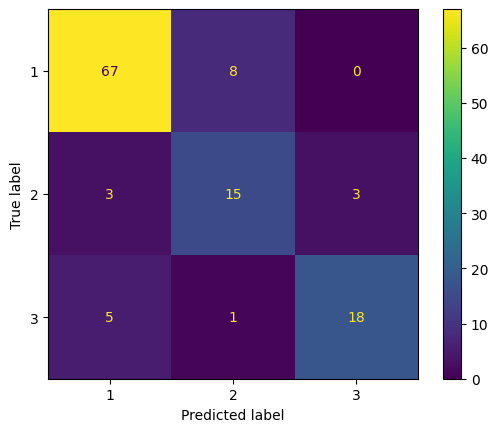

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import loguniform

rf_model = RandomForestClassifier(random_state=77)
dist = {'n_estimators':range(1, 201), 'max_depth':range(2,10), 'min_samples_split':range(2,5)} #limitando máx de profundidad y un min_sample_split (evitar el sobre-ajuste)
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.82 with {'n_estimators': 114, 'min_samples_split': 4, 'max_depth': 7}
Test score: 0.84


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.87      0.92      0.90        75
           2       0.68      0.71      0.70        21
           3       0.89      0.71      0.79        24

    accuracy                           0.84       120
   macro avg       0.82      0.78      0.79       120
weighted avg       0.84      0.84      0.84       120



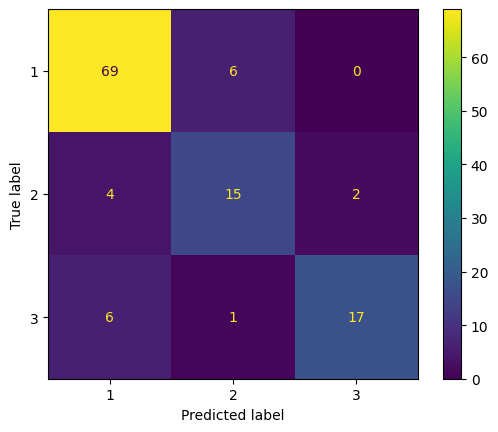

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Una desventaja de estos modelos es que no son tan fáciles de interpretar como los modelos lineales, en los cuales podemos saber con certeza cuando pesa cada característica en la predicción, o los árboles de decisión, en los que se puede construir un grafo que representa las decisiones que se tomaron para hacer una predicción.

Con los modelos de ensamble no tenemos nada de eso, pero en la implementación de Scikit Learn tienen el atributo *features_importances_*, que, como su nombre lo indica, entrega la importancia de cada característica computada mediante el algoritmo de Gini.



In [ ]:
rf_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
rf_features.sort_values('Importance', ascending=False)

,Feature,Importance
2,displacement,0.293881
3,horsepower,0.180171
4,weight,0.172913
0,mpg,0.117271
5,acceleration,0.105326
1,cylinders,0.077434
6,model year,0.053003


# Gradient Boosting

Los modelos de gradient boosting se diferencian de otros métodos de ensamble en que **aprenden de forma aditiva**. Esto significa que cada nuevo árbol de decisión se entrena utilizando los errores de los árboles anteriores, lo que permite al modelo mejorar iterativamente su rendimiento.

**¿Cómo funciona el proceso?**

1. **Árbol inicial:** Se comienza con un **árbol de decisión inicial**, que puede ser un árbol simple o generado aleatoriamente. Este árbol predice los valores para el conjunto de datos.

2. **Errores residuales:** Se calculan los **errores residuales**, que son la diferencia entre las predicciones del árbol inicial y los valores reales del conjunto de datos.

3. **Nuevo árbol:** Se entrena un **nuevo árbol de decisión** utilizando los errores residuales del paso anterior. El objetivo de este nuevo árbol es **corregir los errores del árbol inicial**.

4. **Combinación:** Se **combinan las predicciones del nuevo árbol** con las del árbol inicial. La forma de combinarlas depende del algoritmo específico de gradient boosting utilizado, pero generalmente se utiliza una **ponderación** que refleja la importancia de cada árbol.

5. **Repetición:** Se repiten los pasos 2 a 4, **entrenando un nuevo árbol de decisión** y combinándolo con los anteriores, hasta que se alcanza el número máximo de árboles o se cumple un criterio de parada.

**¿Qué ventajas tienen los modelos de gradient boosting?**

* **Precisión:** Los modelos de gradient boosting pueden ser **muy precisos**, especialmente cuando se utilizan con conjuntos de datos grandes y complejos.
* **Robustez:** Son **robustos a los outliers** y al **ruido** en los datos.
* **Versatilidad:** Se pueden utilizar para una **amplia variedad de tareas de aprendizaje automático**, como regresión, clasificación y problemas de ranking.

**¿Qué desventajas tienen los modelos de gradient boosting?**

* **Sobreajuste:** Si no se tiene cuidado, los modelos de gradient boosting pueden **sobreajustarse** a los datos de entrenamiento, lo que significa que no se generalizan bien a nuevos datos.
* **Computación:** Entrenar un modelo de gradient boosting puede ser **computacionalmente costoso**, especialmente cuando se utilizan conjuntos de datos grandes o un gran número de árboles.



En un modelo de **gradient boosting** se pueden ajustar varios **hiperparámetros** para optimizar su rendimiento. Además de los ya vistos en los árboles de decisión y los bosques aleatorios, estos hiperparámetros adicionales se pueden sintonizar:

* **learning_rate:** Controla el tamaño del paso que se da en la dirección del gradiente durante el entrenamiento. Un valor grande puede conducir a un entrenamiento más rápido, pero también puede aumentar el riesgo de sobreajuste.
* **Función de pérdida (loss):** Define la forma en que se mide el error del modelo. La función de pérdida más común para el gradient boosting es la **función de pérdida cuadrática** para problemas de regresión y la **función de pérdida logarítmica** para problemas de clasificación.
* **Criterio de parada (n_iter_no_change, validation_fraction y tol):** Determina cuándo se detiene el entrenamiento del modelo. Se pueden utilizar diferentes criterios como un cierto nivel de precisión o una mejora mínima en la precisión.

Vamos a entrenar un modelo de *gradient boosting* sintonizando algunos de estos hiperparámetros:

In [ ]:
from sklearn.model_selection import train_test_split

df_dropna = df.dropna()
X = df_dropna.drop(columns=['origin'])
y = df_dropna['origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (274, 7) (274,)
Test: (118, 7) (118,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from scipy.stats import uniform

gb_model = GradientBoostingClassifier(n_iter_no_change=5)
dist = {'n_estimators':range(1, 201), 'max_depth':range(1,10), 'learning_rate':uniform(0,1), 'min_samples_split':range(2,5)}
grid_search = RandomizedSearchCV(estimator=gb_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best score: 0.807 with {'learning_rate': 0.33574626121053397, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 192}
Test score: 0.869


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.89      0.96      0.92        74
           2       0.87      0.65      0.74        20
           3       0.83      0.79      0.81        24

    accuracy                           0.87       118
   macro avg       0.86      0.80      0.82       118
weighted avg       0.87      0.87      0.87       118



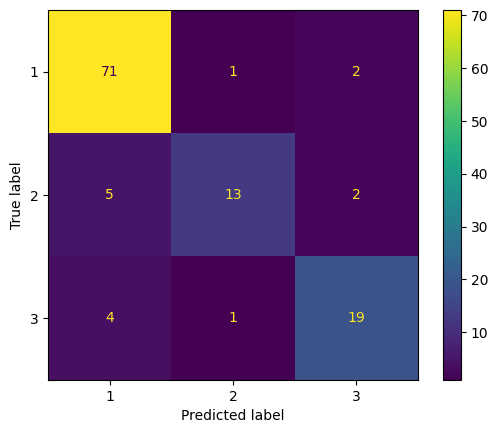

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Estos modelos también entregan la importancia relativa de cada característica en el modelo:

In [ ]:
gb_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
gb_features.sort_values('Importance', ascending=False)

,Feature,Importance
2,displacement,0.530818
3,horsepower,0.142544
5,acceleration,0.120259
4,weight,0.085473
0,mpg,0.073511
6,model year,0.037358
1,cylinders,0.010037


# Modelos de regresión

In [ ]:
from sklearn.model_selection import train_test_split

df_dropna = df.dropna()
X = df_dropna.drop(columns=['mpg'])
y = df_dropna['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (274, 7) (274,)
Test: (118, 7) (118,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.linear_model import Ridge

num_vars = ['displacement', 'horsepower', 'weight', 'acceleration'] # Se definen las variables numéricas
ohe = OneHotEncoder(sparse_output=False, drop='first')
oe_cyl = OrdinalEncoder(categories=[[3., 4., 5., 6., 8.]])
oe_my = OrdinalEncoder(categories=[[70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.]])
poly = PolynomialFeatures(degree=2)
ss = StandardScaler()
pre_num = Pipeline(steps=[('poly', poly), ('ss', ss)])

preprocessor = ColumnTransformer(transformers=[('ohe', ohe, ['origin']), # Codificacióp OneHot para la variable 'origin'
                                               ('oe_cylinders', oe_cyl, ['cylinders']), # Codificación ordinal para la variable 'cylinders'
                                               ('oe_model_year', oe_my, ['model year']), # Codificación ordinal para la variable 'model_year'
                                               ('pre_num', pre_num, num_vars)], # Prepocesamiento de las variables numéricas
                                               remainder='drop') # El resto de las columnas se mantienen sin cambios

pipe = Pipeline([('preprocessor', preprocessor), ('model', Ridge())])
dist = {'model__alpha':loguniform(1e-4, 1e2)}

grid_search = RandomizedSearchCV(estimator=pipe, cv=5, param_distributions=dist, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 3.03 with {'model__alpha': 0.3638829446878262}
Test score: 3.03


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['mpg'])
y = df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (278, 7) (278,)
Test: (120, 7) (120,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error

dist = {'ccp_alpha':loguniform(1e-3, 1e2)}
grid_search = RandomizedSearchCV(estimator=DecisionTreeRegressor(), cv=5, param_distributions=dist, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 3.68 with {'ccp_alpha': 0.8035198899600081}
Test score: 3.59


## Regresor bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

bag_model = BaggingRegressor(estimator=DecisionTreeRegressor())

dist = {'n_estimators':range(1, 201)}
grid_search = RandomizedSearchCV(estimator=bag_model, param_distributions=dist, cv=5, random_state=77, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 2.81 with {'n_estimators': 171}
Test score: 2.73


## Random Forest


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from scipy.stats import loguniform

rf_model = RandomForestRegressor()
dist = {'n_estimators':range(1, 201), 'max_depth':range(2,10), 'min_samples_split':range(2,5)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 2.82 with {'n_estimators': 114, 'min_samples_split': 4, 'max_depth': 7}
Test score: 2.73


In [ ]:
rf_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
rf_features.sort_values('Importance', ascending=False)

,Feature,Importance
3,weight,0.378081
0,cylinders,0.207181
5,model year,0.140076
1,displacement,0.125213
2,horsepower,0.119637
4,acceleration,0.024432
6,origin,0.005379


## Boosting Regressor

In [ ]:
from sklearn.model_selection import train_test_split

df_dropna = df.dropna()
X = df_dropna.drop(columns=['mpg'])
y = df_dropna['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (274, 7) (274,)
Test: (118, 7) (118,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from scipy.stats import loguniform, uniform

gb_model = GradientBoostingRegressor(n_iter_no_change=5)
dist = {'n_estimators':range(1, 201), 'max_depth':range(2,10), 'min_samples_split':range(2,5), 'learning_rate':uniform(0,1), 'loss':['squared_error', 'huber', 'quantile', 'absolute_error']}
grid_search = RandomizedSearchCV(estimator=gb_model, param_distributions=dist, cv=5, random_state=77, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 3.01 with {'learning_rate': 0.7055972446574292, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 125}
Test score: 3.27


In [ ]:
gb_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
gb_features.sort_values('Importance', ascending=False)

,Feature,Importance
0,cylinders,0.590361
2,horsepower,0.130993
5,model year,0.109519
3,weight,0.103917
4,acceleration,0.032903
1,displacement,0.025099
6,origin,0.007208
